In [1]:
from torchvision import transforms,models,datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import torch
import numpy as np
from PIL import Image
import os
from torch import nn
from torchvision.models import vit_b_16
from five_dataset import MyDataset

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## load the dataset 

In [3]:
data_dir='/home/jialiangfan/DTViT/dataset3'
dataset=MyDataset(data_dir)
from torch.utils.data import random_split
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# train_dataset = MyDataset(data_dir,test_frac=0.15,section="training")
# test_dataset=MyDataset(data_dir,test_frac=0.15,section="test")

In [4]:
train_dataloader = DataLoader(train_dataset,batch_size=8)
test_dataloader = DataLoader(test_dataset,batch_size=8)

In [5]:
from models.resnet import DualResNet

model = DualResNet(num_classe1=2, num_classe2=3)

for name, moudle in model.named_children():
    print(name)
    print(moudle)
    print('------------------')
# print(model.named_children)
# aa=nn.Sequential(*list(model.children())[:-1])



backbone
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from torchsummary import summary
summary(model, (3, 224, 224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

In [7]:
type(model),type(model.encoder)

(models.resnet.DualResNet, torch.nn.modules.container.Sequential)

In [8]:
model.to(device)

DualResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
import torch.optim as optim
criterion1 = nn.CrossEntropyLoss()  #(set loss function)
criterion2 = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
import time
num_epochs = 50   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0 #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, inputs in enumerate(train_dataloader):
        image=inputs['pixel_values']
        labels1=inputs['label1']
        labels2=inputs['label2']
        # move to GPU
        image = image.to(device)
        labels1 = labels1.to(device) 
        labels2 = labels2.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        pre_labels1,pre_labels2 = model(image)
        # print("pre_labels",pre_labels1.shape,pre_labels2.shape)
        _, preds1 = torch.max(pre_labels1, 1)
        _, preds2 = torch.max(pre_labels2, 1)
        # print("type",preds1.dtype,labels1.dtype)
        # print("preds",preds1,preds2)
        # print("labels",labels1,labels2)
        loss1 = criterion1(pre_labels1,labels1)
        loss2=criterion2(pre_labels2,labels2)
        # 两个分类loss之和
        loss=loss1+loss2
        # print("loss",loss)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * image.size(0)
        # print("size",pre_labels1.size(),labels1.size())
        # print("data",labels1.data)
        # 两个分类的正确数
        running_corrects += torch.sum(preds1 == labels1.data)
        running_corrects += torch.sum(preds2 == labels2.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / (len(train_dataset)*2) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    # """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for index, inputs  in enumerate(test_dataloader):
            image, labels1,labels2 = inputs['pixel_values'],inputs['label1'],inputs['label2']
            image = image.to(device)
            labels1= labels1.to(device)
            labels2= labels2.to(device)
            outputs1,outputs2 = model(image)
            _, preds1 = torch.max(outputs1, 1)
            _, preds2 = torch.max(outputs2, 1)

# 
            loss1 = criterion1(outputs1, labels1)
            loss2 = criterion2(outputs2, labels2)
            loss = loss1 + loss2
            running_loss += loss.item() * image.size(0)

            running_corrects += torch.sum(preds1 == labels1.data)
            running_corrects += torch.sum(preds2 == labels2.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / (2*len(test_dataset))* 100
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #0] Loss: 0.3863 Acc: 93.0147% Time: 49.4947s
[Test #0] Loss: 0.3186 Acc: 92.8620% Time: 56.3776s
Epoch 1 running
[Train #1] Loss: 0.1708 Acc: 97.0920% Time: 99.8624s
[Test #1] Loss: 0.1907 Acc: 96.2594% Time: 106.5859s
Epoch 2 running
[Train #2] Loss: 0.1085 Acc: 98.1825% Time: 149.5380s
[Test #2] Loss: 0.1265 Acc: 97.5292% Time: 156.1474s
Epoch 3 running
[Train #3] Loss: 0.0699 Acc: 98.7944% Time: 198.8420s
[Test #3] Loss: 0.2105 Acc: 96.1222% Time: 205.3007s
Epoch 4 running
[Train #4] Loss: 0.0504 Acc: 99.1639% Time: 251.4669s
[Test #4] Loss: 0.0503 Acc: 99.1421% Time: 257.8882s
Epoch 5 running
[Train #5] Loss: 0.0579 Acc: 99.1579% Time: 300.3231s
[Test #5] Loss: 0.0595 Acc: 98.5930% Time: 306.6568s
Epoch 6 running
[Train #6] Loss: 0.0265 Acc: 99.6910% Time: 348.9996s
[Test #6] Loss: 0.0408 Acc: 99.2107% Time: 355.2946s
Epoch 7 running
[Train #7] Loss: 0.0242 Acc: 99.6971% Time: 401.8044s
[Test #7] Loss: 0.0355 Acc: 99.4166% Time: 408.0877s
Epoch 8 running
[Tr

FileNotFoundError: [Errno 2] No such file or directory: '/home/jialiangfan/DTViT/dataset3/yes/Deep/3994-2019_filtered-1shuqing-777877.jpg'

In [33]:
save_path = 'five-resnet_unfreeze_pretrained.pth'
torch.save(model.state_dict(), save_path)

## load the pretrained model

In [34]:
model = DualResNet(num_classe1=2, num_classe2=3)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

======>RESULTS<======


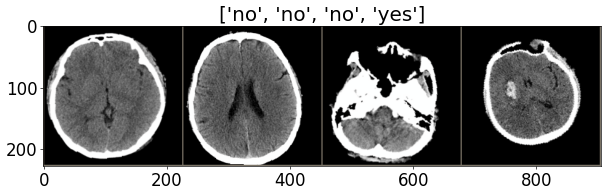

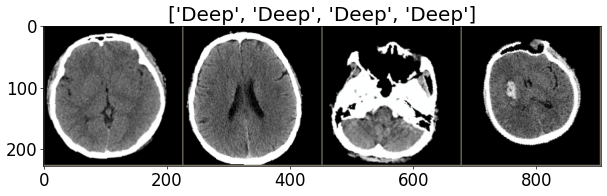

[Test #49] Loss: 0.0303 Acc: 99.6225% Time: 4.6339s


In [39]:
import matplotlib.pyplot as plt
import torchvision

class_names1 = ['no', 'yes']
class_names2 = ['Deep', 'Lobar','Subtentorial']

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
##Testing
model.eval()
model.to(device)
start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for index, inputs  in enumerate(test_dataloader):
        image, labels1,labels2 = inputs['pixel_values'],inputs['label1'],inputs['label2']
        image = image.to(device)
        labels1= labels1.to(device)
        labels2= labels2.to(device)
        outputs1,outputs2  = model(image)
        _, preds1 = torch.max(outputs1, 1)
        _, preds2 = torch.max(outputs2, 1)

        loss1 = criterion1(outputs1, labels1)
        loss2 = criterion2(outputs2, labels2)
        loss = loss1 + loss2
        running_loss += loss.item() * image.size(0)
        running_corrects += torch.sum(preds1 == labels1.data)
        running_corrects += torch.sum(preds2 == labels2.data)
        if index == 0:
            print('======>RESULTS<======')
            images = torchvision.utils.make_grid(image[:4])
            imshow(images.cpu(), title=[class_names1[x] for x in labels1[:4]])
            imshow(images.cpu(), title=[class_names2[x] for x in labels2[:4]])
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / (2* len(test_dataset)) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
          format(epoch, epoch_loss, epoch_acc, time.time() - start_time))